## 1. Packages

In [1]:
#!pip install bitfinex-tencars
#!pip install yfinance
#!pip install pystan==2.17.1.0
#!pip install fbprophet==0.6

In [27]:
# import libraries

# base
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# api
import yfinance as yf
import bitfinex

# time-series forecasting
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, plot_components_plotly

# configuration
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

# others
from datetime import datetime, timedelta, date
import time

ModuleNotFoundError: No module named 'fbprophet'

## 2. Practice

### API V1

In [ ]:
# Ex.1 Get current ticker data for a pair
api = bitfinex.api_v1() # Initialize the api
pair = 'btcusd' # Select a trading pair
api.ticker(pair) # Get the current ticker data

In [ ]:
# Ex.2 Find all available currency pairs
api = bitfinex.api_v1()
symbols = api.symbols()

In [ ]:
# Ex.3 Check account balance
key = 'YOUR_PUBLIC_KEY'
secrete = 'YOUR_SECRETE_KEY'
api = bitfinex.api_v1(key, secrete)
my_balance = api_bitfinex.balance()

In [ ]:
# Ex.4 Place a buy or sell order
symbol = 'btcusd' # Currency pair to trade
amount = '0' # Amount to buy
price = '0' # Buy price
side = 'buy' # Buy or sell
type = 'exchange market' # buy order type

api.place_order(symbol, amount, price, side, type) # Send the order

### API V2: Fetch minute BTC/USD data

In [2]:
btc_historical = pd.read_csv('../../btc_historical.csv', parse_dates=["time"], index_col="time")

In [3]:
btc_historical

,open,close,high,low,volume
time,,,,,
2013-04-01 00:07:00,93.250000,93.30,93.30,93.250000,93.300000
2013-04-01 00:08:00,100.000000,100.00,100.00,100.000000,93.300000
2013-04-01 00:09:00,93.300000,93.30,93.30,93.300000,33.676862
2013-04-01 00:11:00,93.350000,93.47,93.47,93.350000,20.000000
2013-04-01 00:12:00,93.470000,93.47,93.47,93.470000,2.021627
...,...,...,...,...,...
2021-12-08 17:32:00,50391.000000,50388.00,50393.00,50387.006641,0.116263
2021-12-08 17:33:00,50386.000000,50374.00,50386.00,50361.728808,0.730946
2021-12-08 17:34:00,50374.000000,50350.00,50374.00,50342.000000,0.821998


In [51]:
# Define a function to fetch currency pair's historical data in sub queries
def fetchData(start, stop, symbol, interval, limit, step):
    # Create api instance
    api = bitfinex.api_v2()

    data = []
    start = start - step
    while start < stop:

        start = start + step
        end = start + step
        result = api.candles(start=start, end=end, symbol=symbol, interval=interval, limit=limit)
        data.extend(result)
        print('Retrieving data from {} to {} for {}'.format(pd.to_datetime(start, unit='ms'),
                                                            pd.to_datetime(end, unit='ms'), symbol))
        time.sleep(1)
    return data

In [5]:
# Define query parameters
symbol = 'BTCUSD' # currenty pair
interval = '1m' # time resolution
limit = 10000 # datapoints per call (in minutes)
step = 1000 * 60 * limit # size of each subquery in milliseconds

# Fill in the start and end time of interest and convert it to miliseconds
start = btc_historical.index[-1]
start = time.mktime(start.timetuple()) * 1000 
stop = datetime.now()
stop = time.mktime(stop.timetuple()) * 1000

# Fetch the data
pair_data = fetchData(start=start, stop=stop, symbol=symbol, interval=interval, limit=limit, step=step)

No keys, only access to public API functions
Retrieving data from 2021-12-08 16:36:00 to 2021-12-15 15:16:00 for BTCUSD
Retrieving data from 2021-12-15 15:16:00 to 2021-12-22 13:56:00 for BTCUSD
Retrieving data from 2021-12-22 13:56:00 to 2021-12-29 12:36:00 for BTCUSD
Retrieving data from 2021-12-29 12:36:00 to 2022-01-05 11:16:00 for BTCUSD
Retrieving data from 2022-01-05 11:16:00 to 2022-01-12 09:56:00 for BTCUSD
Retrieving data from 2022-01-12 09:56:00 to 2022-01-19 08:36:00 for BTCUSD
Retrieving data from 2022-01-19 08:36:00 to 2022-01-26 07:16:00 for BTCUSD
Retrieving data from 2022-01-26 07:16:00 to 2022-02-02 05:56:00 for BTCUSD
Retrieving data from 2022-02-02 05:56:00 to 2022-02-09 04:36:00 for BTCUSD
Retrieving data from 2022-02-09 04:36:00 to 2022-02-16 03:16:00 for BTCUSD
Retrieving data from 2022-02-16 03:16:00 to 2022-02-23 01:56:00 for BTCUSD
Retrieving data from 2022-02-23 01:56:00 to 2022-03-02 00:36:00 for BTCUSD
Retrieving data from 2022-03-02 00:36:00 to 2022-03-08 

In [6]:
# Remove error messages
ind = [np.ndim(x) != 0 for x in pair_data]
pair_data = [i for (i, v) in zip(pair_data, ind) if v]

# Create pandas data frame and clean data
names = ['time', 'open', 'close', 'high', 'low', 'volume']
df = pd.DataFrame(pair_data, columns=names)
df.drop_duplicates(inplace=True)
df['time'] = pd.to_datetime(df['time'], unit='ms')
df.set_index('time', inplace=True)
df.sort_index(inplace=True)
df.head()

,open,close,high,low,volume
time,,,,,
2021-12-08 16:36:00,50430.909925,50380.000000,50431.0,50343.0,8.716847
2021-12-08 16:37:00,50377.000000,50334.000000,50409.0,50332.0,1.435971
2021-12-08 16:38:00,50351.000000,50429.833559,50435.0,50351.0,0.801555
2021-12-08 16:39:00,50429.000000,50324.000000,50448.0,50311.0,19.881724
2021-12-08 16:40:00,50320.000000,50300.000000,50325.0,50293.0,4.580600


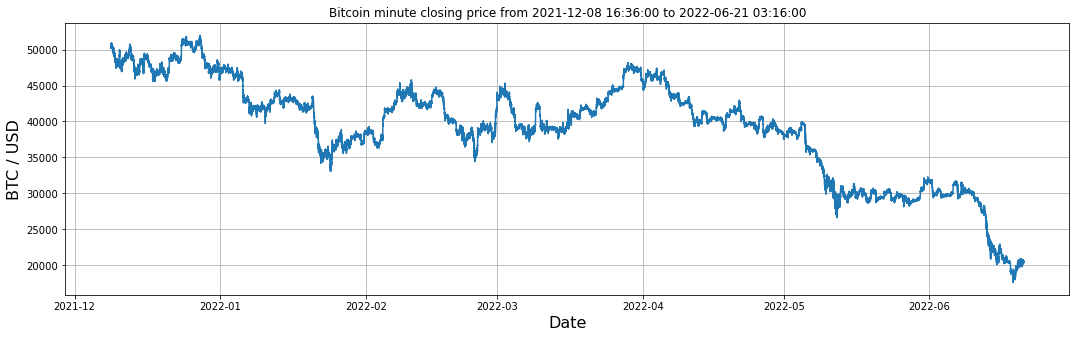

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(18, 5))

ax.plot(df['close'])
ax.set_xlabel('Date', fontsize=16)
ax.set_ylabel('BTC / USD', fontsize=16)
ax.set_title('Bitcoin minute closing price from {} to {}'.format(df.index[0], df.index[-1]))
ax.grid()

plt.show()

In [10]:
btc_historical = btc_historical.append(df)
btc_historical = btc_historical.loc[~btc_historical.index.duplicated(keep='first'), :]
print(f"Are index values unique? {btc_historical.index.is_unique}")
print(f"Number of duplicated indexes: {btc_historical.index.duplicated().sum()}")
btc_historical.to_csv('../../btc_historical.csv')

Are index values unique? True
Number of duplicated indexes: 0


### Yahoo Finance API

In [45]:
btc_day = yf.Ticker('BTC-USD').history(period='10y')[['Close', 'Open', 'High', 'Volume', 'Low']]

In [46]:
# downsampling from minute data to daily data
'''btc_minute = pd.read_csv('../../btc_historical.csv', parse_dates=["Time"], index_col="time")
# remove duplicate indexes
btc_minute = btc_minute.loc[~btc_minute.index.duplicated(keep='first'), :]
print(btc_minute.index.is_unique)
print(btc_minute.index.duplicated().sum())
# resample from minutes to days
btc_day = btc_minute.resample("D").mean().dropna()'''

'btc_minute = pd.read_csv(\'../../btc_historical.csv\', parse_dates=["Time"], index_col="time")\n# remove duplicate indexes\nbtc_minute = btc_minute.loc[~btc_minute.index.duplicated(keep=\'first\'), :]\nprint(btc_minute.index.is_unique)\nprint(btc_minute.index.duplicated().sum())\n# resample from minutes to days\nbtc_day = btc_minute.resample("D").mean().dropna()'

## 3. Data Extraction & Prep

We extract the historical daily BTC/USD data from the bitfinex API. 

In [3]:
# Define query parameters
symbol = 'BTCUSD' # currenty pair
interval = '1D' # time resolution
limit = 10000 # datapoints per call with timeunit = interval

# Fetch the data
pair_data = bitfinex.api_v2().candles(symbol=symbol, interval=interval, limit=limit)

No keys, only access to public API functions


2.2 Data Cleaning

In [6]:
# Remove error messages
ind = [np.ndim(x) != 0 for x in pair_data]
pair_data = [i for (i, v) in zip(pair_data, ind) if v]

# Create pandas data frame and clean data
names = ['Time', 'Open', 'Close', 'High', 'Low', 'Volume']
df = pd.DataFrame(pair_data, columns=names)
df.drop_duplicates(inplace=True)
df['Time'] = pd.to_datetime(df['Time'], unit='ms')
df.set_index('Time', inplace=True)
df.sort_index(inplace=True)

In [7]:
df.head()

,Open,Close,High,Low,Volume
Time,,,,,
2013-03-31,92.500000,93.033000,93.74999,91.00000,3083.079791
2013-04-01,93.250000,103.999000,105.90000,92.49999,5224.401313
2013-04-02,104.000000,118.229354,118.38670,99.00000,8376.527478
2013-04-03,117.958261,134.700000,146.88000,101.51088,12996.245072
2013-04-04,134.716560,132.899000,143.00000,119.00000,6981.668305


In [8]:
df.shape

(3379, 5)

In [10]:
df.Close.describe()

count     3379.000000
mean     10554.528092
std      15836.233802
min         66.120000
25%        450.580000
50%       3978.100000
75%      10265.000000
max      67526.000000
Name: Close, dtype: float64

## 4. Feature Engineering

#### 50-100-200 Weekly SMA

In [11]:
btc_day["SMA5W"] = btc_day["Close"].rolling(7*5).mean()
btc_day["SMA20W"] = btc_day["Close"].rolling(7*20).mean()
btc_day["SMA50W"] = btc_day["Close"].rolling(7*50).mean()
btc_day["SMA100W"] = btc_day["Close"].rolling(7*100).mean()
btc_day["SMA200W"] = btc_day["Close"].rolling(7*200).mean()

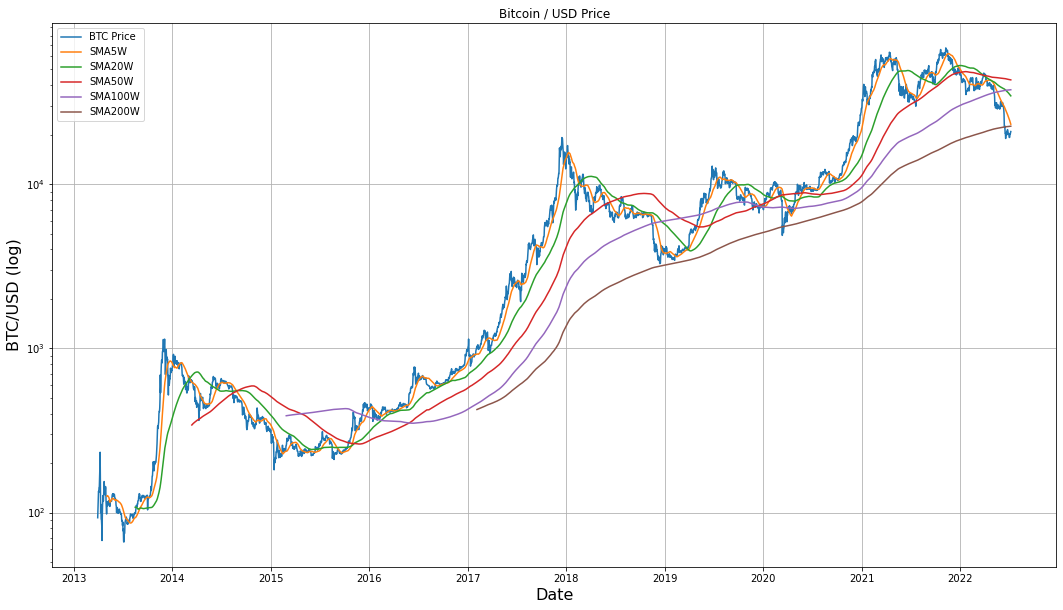

In [12]:
plt.figure(figsize=(18,10))
plt.plot(btc_day.loc["2013":, ["Close", "SMA5W", "SMA20W", "SMA50W", "SMA100W", "SMA200W"]])
plt.xlabel('Date', fontsize=16)
plt.ylabel('BTC/USD (log)', fontsize=16)
plt.title('Bitcoin / USD Price')
plt.yscale('log')
plt.legend(["BTC Price", "SMA5W", "SMA20W", "SMA50W", "SMA100W", "SMA200W"] , loc="upper left")
plt.grid()
plt.show()

#### The Golden Ratio Multiplier

In [13]:
btc_day["350DMA"] = btc_day["Close"].rolling(350).mean()
btc_day["GRM0.5"] = btc_day["Close"].rolling(350).mean()*0.5
btc_day["GRM1.6"] = btc_day["Close"].rolling(350).mean()*1.6
btc_day["GRM2"] = btc_day["Close"].rolling(350).mean()*2
btc_day["GRM3"] = btc_day["Close"].rolling(350).mean()*3
btc_day["GRM5"] = btc_day["Close"].rolling(350).mean()*5
btc_day["GRM8"] = btc_day["Close"].rolling(350).mean()*8

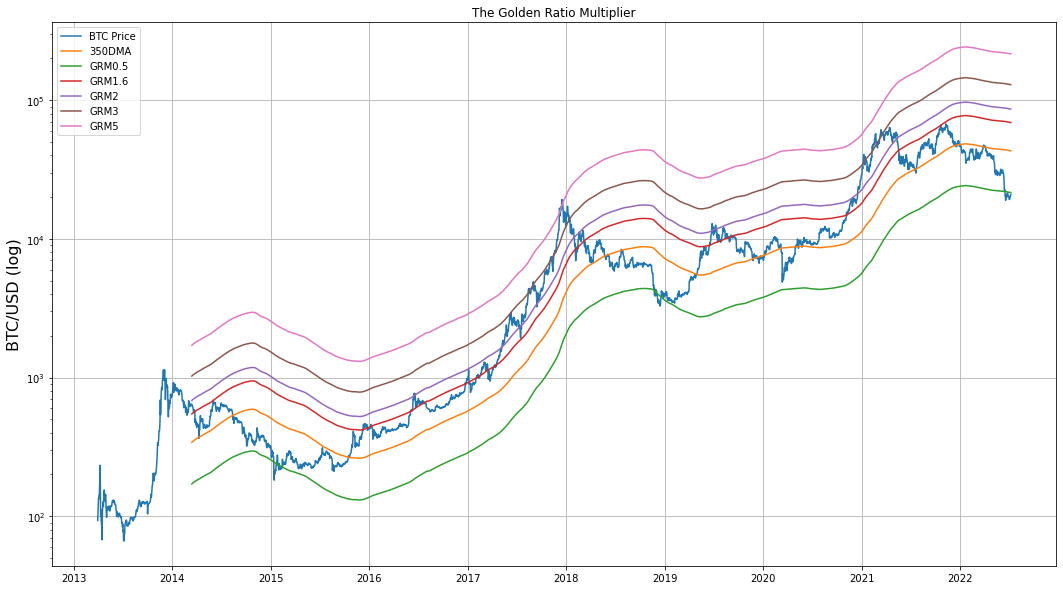

In [14]:
plt.figure(figsize=(18,10))
plt.plot(btc_day.loc["2013":, ["Close", "350DMA", "GRM0.5", "GRM1.6", "GRM2", "GRM3", "GRM5"]])
plt.ylabel('BTC/USD (log)', fontsize=16)
plt.title('The Golden Ratio Multiplier')
plt.yscale('log')
plt.legend(["BTC Price", "350DMA", "GRM0.5", "GRM1.6", "GRM2", "GRM3", "GRM5"] , loc="upper left")
plt.grid()
plt.show()

#### MACD

In [94]:

# # Calculate MACD values using the pandas_ta library
# df.ta.macd(close='close', fast=12, slow=26, signal=9, append=True)

# Get the 26-day EMA of the closing price
k = btc_day['Close'].ewm(span=12, adjust=False, min_periods=12).mean()
# Get the 12-day EMA of the closing price
d = btc_day['Close'].ewm(span=26, adjust=False, min_periods=26).mean()
# Subtract the 26-day EMA from the 12-Day EMA to get the MACD
macd = k - d
# Get the 9-Day EMA of the MACD for the Trigger line
macd_s = macd.ewm(span=9, adjust=False, min_periods=9).mean()
# Calculate the difference between the MACD - Trigger for the Convergence/Divergence value
macd_h = macd - macd_s
# Add all of our new values for the MACD to the dataframe
btc_day['macd'] = btc_day.index.map(macd)
btc_day['macd_h'] = btc_day.index.map(macd_h)
btc_day['macd_s'] = btc_day.index.map(macd_s)